# Installs & Imports

In [1]:
!pip install -q tbats

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tbats import TBATS
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Data Loading

In [3]:
# Load the dataset
DATA_URL = "https://raw.githubusercontent.com/ejgao/Time-Series-Datasets/master/monthly-beer-production-in-austr.csv"

try:
    beer_df = pd.read_csv(
        DATA_URL,
        parse_dates=["Month"],
        index_col="Month"
    )
    beer_df.index.freq = "MS"  # Set frequency to Month Start
    beer_df.rename(columns={"Monthly beer production": "BeerProduction"}, inplace=True)
except Exception as error:
    print(f"Failed to load data from {DATA_URL}. Error: {error}")
    raise SystemExit(error)

print("Dataset Head:")
display(beer_df.head())
print("\nDataset Tail:")
display(beer_df.tail())

Dataset Head:


,BeerProduction
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9



Dataset Tail:


,BeerProduction
Month,
1995-04-01,127.0
1995-05-01,151.0
1995-06-01,130.0
1995-07-01,119.0
1995-08-01,153.0


Dataset Shape: (476, 1)

Descriptive Statistics:


,BeerProduction
count,476.000000
mean,136.395378
std,33.738725
min,64.800000
25%,112.900000
50%,139.150000
75%,158.825000
max,217.800000


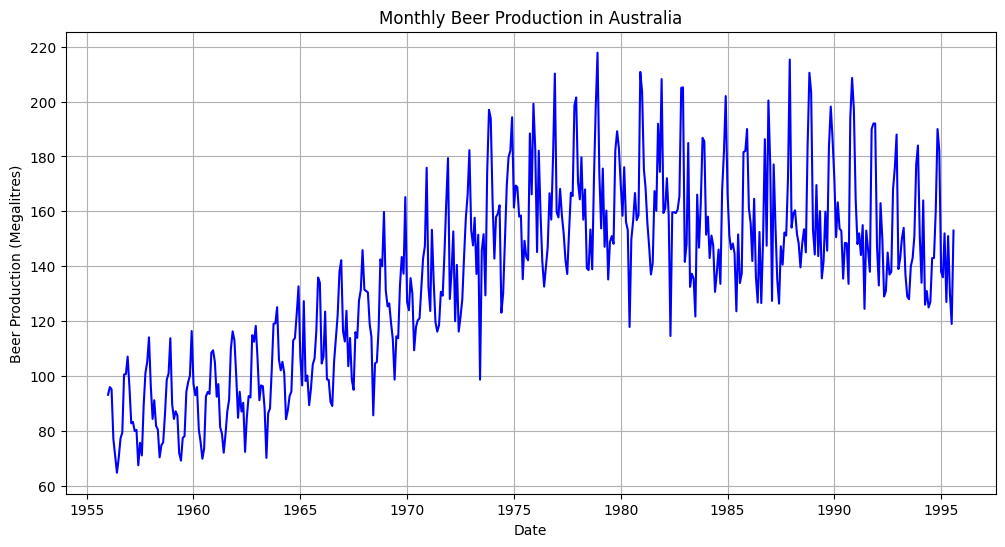

In [4]:
# Data exploration
print(f"Dataset Shape: {beer_df.shape}\n")
print("Descriptive Statistics:")
display(beer_df.describe())

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(beer_df.index, beer_df['BeerProduction'], color='blue')
plt.title('Monthly Beer Production in Australia')
plt.xlabel('Date')
plt.ylabel('Beer Production (Megalitres)')
plt.grid(True)
plt.show()

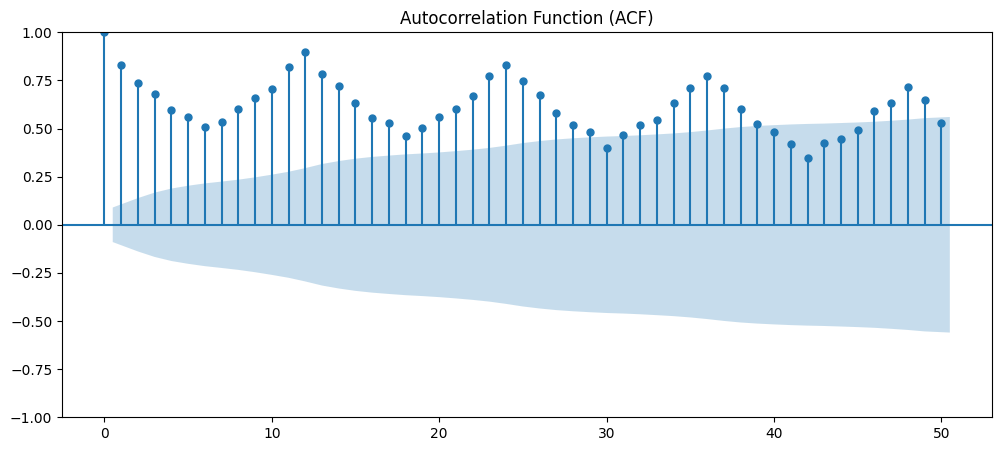

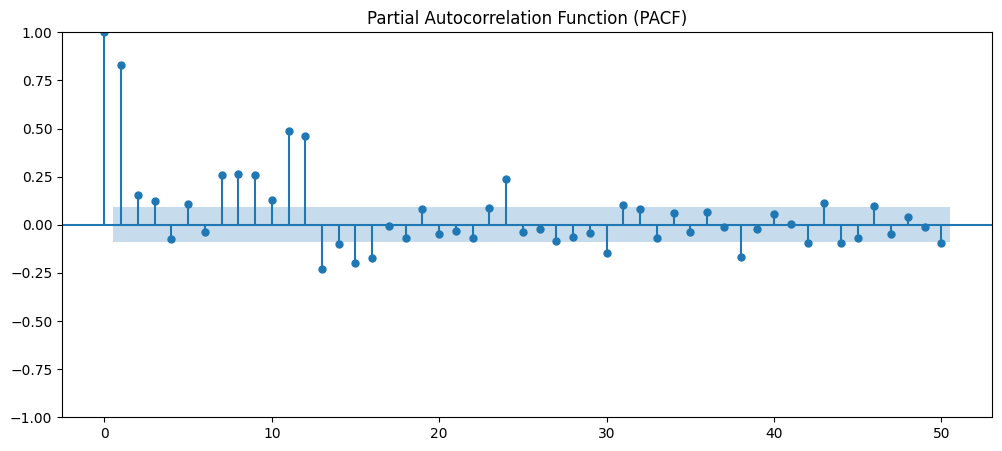

In [5]:
# Plot ACF and PACF
plt.figure(figsize=(12,5))
plot_acf(beer_df['BeerProduction'], lags=50, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')
plt.show()

plt.figure(figsize=(12,5))
plot_pacf(beer_df['BeerProduction'], lags=50, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

# Data Preparation

In [6]:
# Data preparation (Train/Test Split)

# Define the number of periods to forecast
TEST_PERIODS = 24  # Last 24 months as test set

# Split the data
train_data = beer_df.iloc[:-TEST_PERIODS]
test_data = beer_df.iloc[-TEST_PERIODS:]

print(f"Training Set Shape: {train_data.shape}")
print(f"Testing Set Shape: {test_data.shape}")

Training Set Shape: (452, 1)
Testing Set Shape: (24, 1)


# Model Initialization

In [7]:
# ===== SARIMAX Configuration =====
SARIMAX_ORDER = (1, 1, 1)
SARIMAX_SEASONAL_ORDER = (1, 1, 1, 12)  # Seasonal order with monthly seasonality

sarimax_model = SARIMAX(
    endog=train_data['BeerProduction'],
    order=SARIMAX_ORDER,
    seasonal_order=SARIMAX_SEASONAL_ORDER,
    enforce_stationarity=False,
    enforce_invertibility=False
)

In [8]:
# Disable FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# ===== TBATS Configuration =====
tbats_model_initializer = TBATS(
    seasonal_periods=[12],      # Monthly seasonality
    use_arma_errors=None,       # Let TBATS decide whether to use ARMA errors
    use_box_cox=None,           # Allow TBATS to decide on Box-Cox transformation
    use_trend=None,             # Let TBATS decide on trend component
    use_damped_trend=None,      # Let TBATS decide on damping trend
    show_warnings=False         # Do not show warnings
)

# Model Fitting

In [9]:
# SARIMAX model fitting
print("Fitting SARIMAX model...")
sarimax_results = sarimax_model.fit(disp=False)
print("SARIMAX Model Summary:")
print(sarimax_results.summary())

Fitting SARIMAX model...
SARIMAX Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:                     BeerProduction   No. Observations:                  452
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1592.200
Date:                            Fri, 10 Jan 2025   AIC                           3194.400
Time:                                    06:13:00   BIC                           3214.661
Sample:                                01-01-1956   HQIC                          3202.404
                                     - 08-01-1993                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1653      0.042     -3.979      0.000      -0.247

In [10]:
# Disable FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# TBATS model fitting
print("Fitting TBATS model...")
tbats_fitted_model = tbats_model_initializer.fit(train_data['BeerProduction'])
print("TBATS Model Fitted Successfully.")

Fitting TBATS model...
TBATS Model Fitted Successfully.


In [11]:
# Inspect TBATS model components
tbats_components = tbats_fitted_model.params.components
print("TBATS Model Components:")
print(f"Seasonal Periods: {tbats_components.seasonal_periods}")
print(f"Harmonics per Season: {tbats_components.seasonal_harmonics}")
print(f"Trend Component: {tbats_components.use_trend}")
print(f"Damped Trend: {tbats_components.use_damped_trend}")
print(f"Box-Cox Transformation Used: {tbats_components.use_box_cox}")
print(f"ARMA Errors Used: {tbats_components.use_arma_errors}")

TBATS Model Components:
Seasonal Periods: [12.]
Harmonics per Season: [5]
Trend Component: True
Damped Trend: True
Box-Cox Transformation Used: True
ARMA Errors Used: False


# Metrics Evaluation

In [12]:
# ===== SARIMAX Predictions =====
sarimax_forecast = sarimax_results.predict(
    start=test_data.index[0],
    end=test_data.index[-1]
)

In [13]:
# Disable FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# ===== TBATS Predictions =====
tbats_forecast_values = tbats_fitted_model.forecast(steps=TEST_PERIODS)
tbats_forecast = pd.Series(tbats_forecast_values, index=test_data.index)

In [14]:
# ===== Define Evaluation Metrics =====
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def calculate_mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [15]:
# ===== Compute Metrics for SARIMAX =====
sarimax_rmse = calculate_rmse(test_data['BeerProduction'], sarimax_forecast)
sarimax_mae = calculate_mae(test_data['BeerProduction'], sarimax_forecast)
sarimax_mape = calculate_mape(test_data['BeerProduction'], sarimax_forecast)

In [16]:
# ===== Compute Metrics for TBATS =====
tbats_rmse = calculate_rmse(test_data['BeerProduction'], tbats_forecast)
tbats_mae = calculate_mae(test_data['BeerProduction'], tbats_forecast)
tbats_mape = calculate_mape(test_data['BeerProduction'], tbats_forecast)

In [17]:
# ===== Compile Metrics into a DataFrame =====
evaluation_metrics = pd.DataFrame({
    'Model': ['SARIMAX', 'TBATS'],
    'RMSE': [sarimax_rmse, tbats_rmse],
    'MAE': [sarimax_mae, tbats_mae],
    'MAPE (%)': [sarimax_mape, tbats_mape]
})

print("Model Evaluation Metrics:")
display(evaluation_metrics)

Model Evaluation Metrics:


,Model,RMSE,MAE,MAPE (%)
0,SARIMAX,10.207325,8.605780,6.008411
1,TBATS,9.822764,8.410233,5.881142


# Forecast Plotting

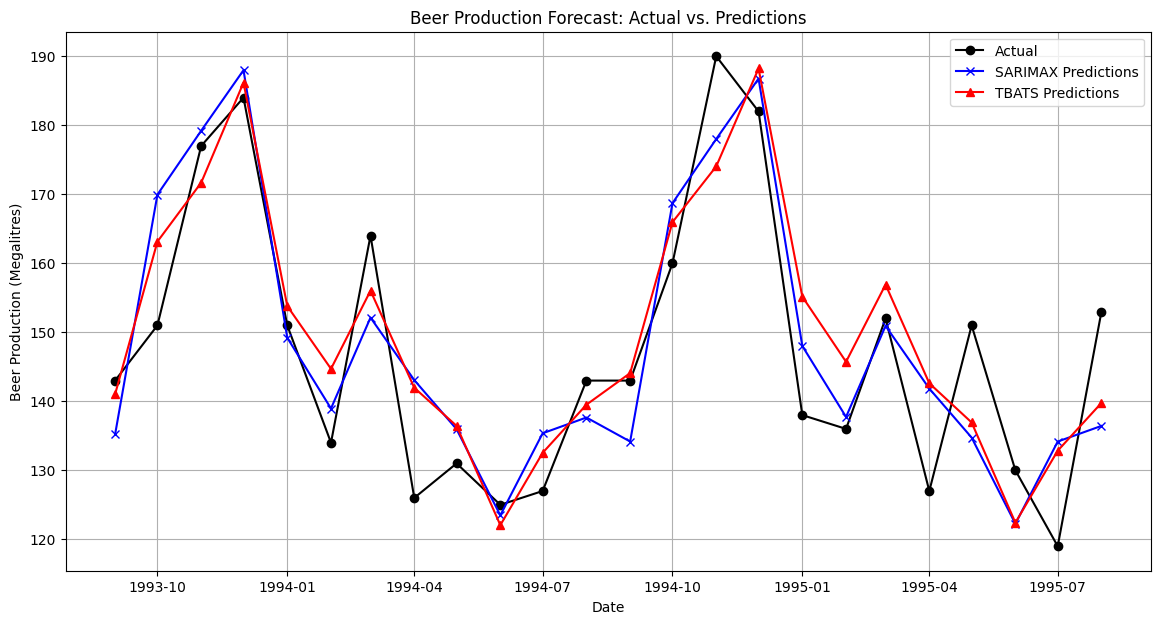

In [18]:
# Forecast Plotting
plt.figure(figsize=(14, 7))

# Plot actual values
plt.plot(test_data.index, test_data['BeerProduction'], label='Actual', color='black', marker='o')

# Plot SARIMAX predictions
plt.plot(test_data.index, sarimax_forecast, label='SARIMAX Predictions', color='blue', marker='x')

# Plot TBATS predictions
plt.plot(test_data.index, tbats_forecast, label='TBATS Predictions', color='red', marker='^')

plt.title('Beer Production Forecast: Actual vs. Predictions')
plt.xlabel('Date')
plt.ylabel('Beer Production (Megalitres)')
plt.legend()
plt.grid(True)
plt.show()